In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from importlib import reload
#import after torch else crash on Intel
from scipy.optimize import least_squares

from libs_unet.models import peakyfinder_0003
from libs_unet.training.spec_maker import spectrum_maker

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [2]:
#Load training data for testing
with open(datapath / 'training' / 'el80_pairs_lg.pickle', 'rb') as f:
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)
    fracs = pickle.load(f)
    wave = pickle.load(f)
    spec_data = pickle.load(f)
# set number of elements
max_z = len(elem_symb)

In [3]:
#Scale data to account for source
nist_mult = 1.17
spec_data = nist_mult * spec_data

In [4]:
#split x_data into mutex low_int and log(hi_int) input channels
x_data = spec_data[:,None,:].copy()
x_shape = x_data.shape
new_inp = np.zeros((x_shape[0], 2, x_shape[2]))
log_cut = 2
new_inp[:,0,:] = np.where(np.log(x_data[:,0,:]) < log_cut, x_data[:,0,:], 0)
new_inp[:,1,:] = np.where(np.log(x_data[:,0,:]) >= log_cut, np.log(x_data[:,0,:]), 0)
x_data = new_inp.copy()
new_inp = None

In [5]:
#Create Dataset#
x_data = torch.tensor(x_data.astype('float32'))
x_data[x_data < 0] = 0
y_data = torch.tensor(fracs.astype('float32'))
#create dataset/dataloader for accessing/iterating
spec_ds = TensorDataset(x_data, y_data)
pred_bs = 1000
spec_dl = DataLoader(spec_ds, batch_size=pred_bs)


In [6]:
#Load model and parameters for making predictions
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = peakyfinder_0003.LIBSUNet(max_z,len(wave))
param_path = top_dir / 'trained_models' / 'TPU_HiLo_Fracs_0003'
model.load_state_dict(torch.load(param_path))


<All keys matched successfully>

In [7]:
#Run predictions for the entire dataset
model.eval()
with torch.no_grad():
    pred = torch.tensor([])
    for batch, X in enumerate(spec_dl):
        pred = torch.cat((pred, model(X[0])), dim=0)

Sample composition
C:0.400
Sc:0.600
Model Prediction
max raw pred: 0.56
C:0.352
Sc:0.595
Sm:0.054


Text(0, 0.5, 'log intensity')

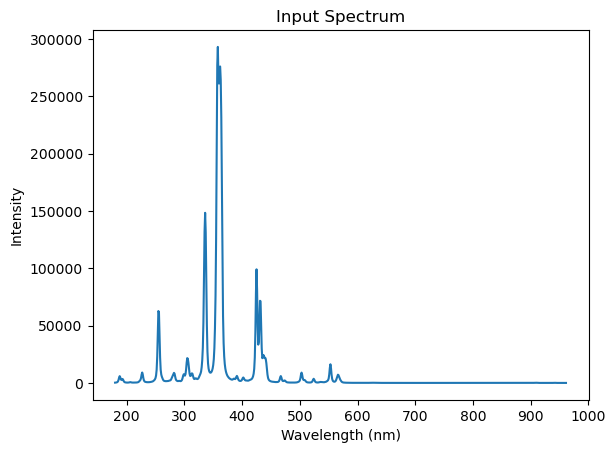

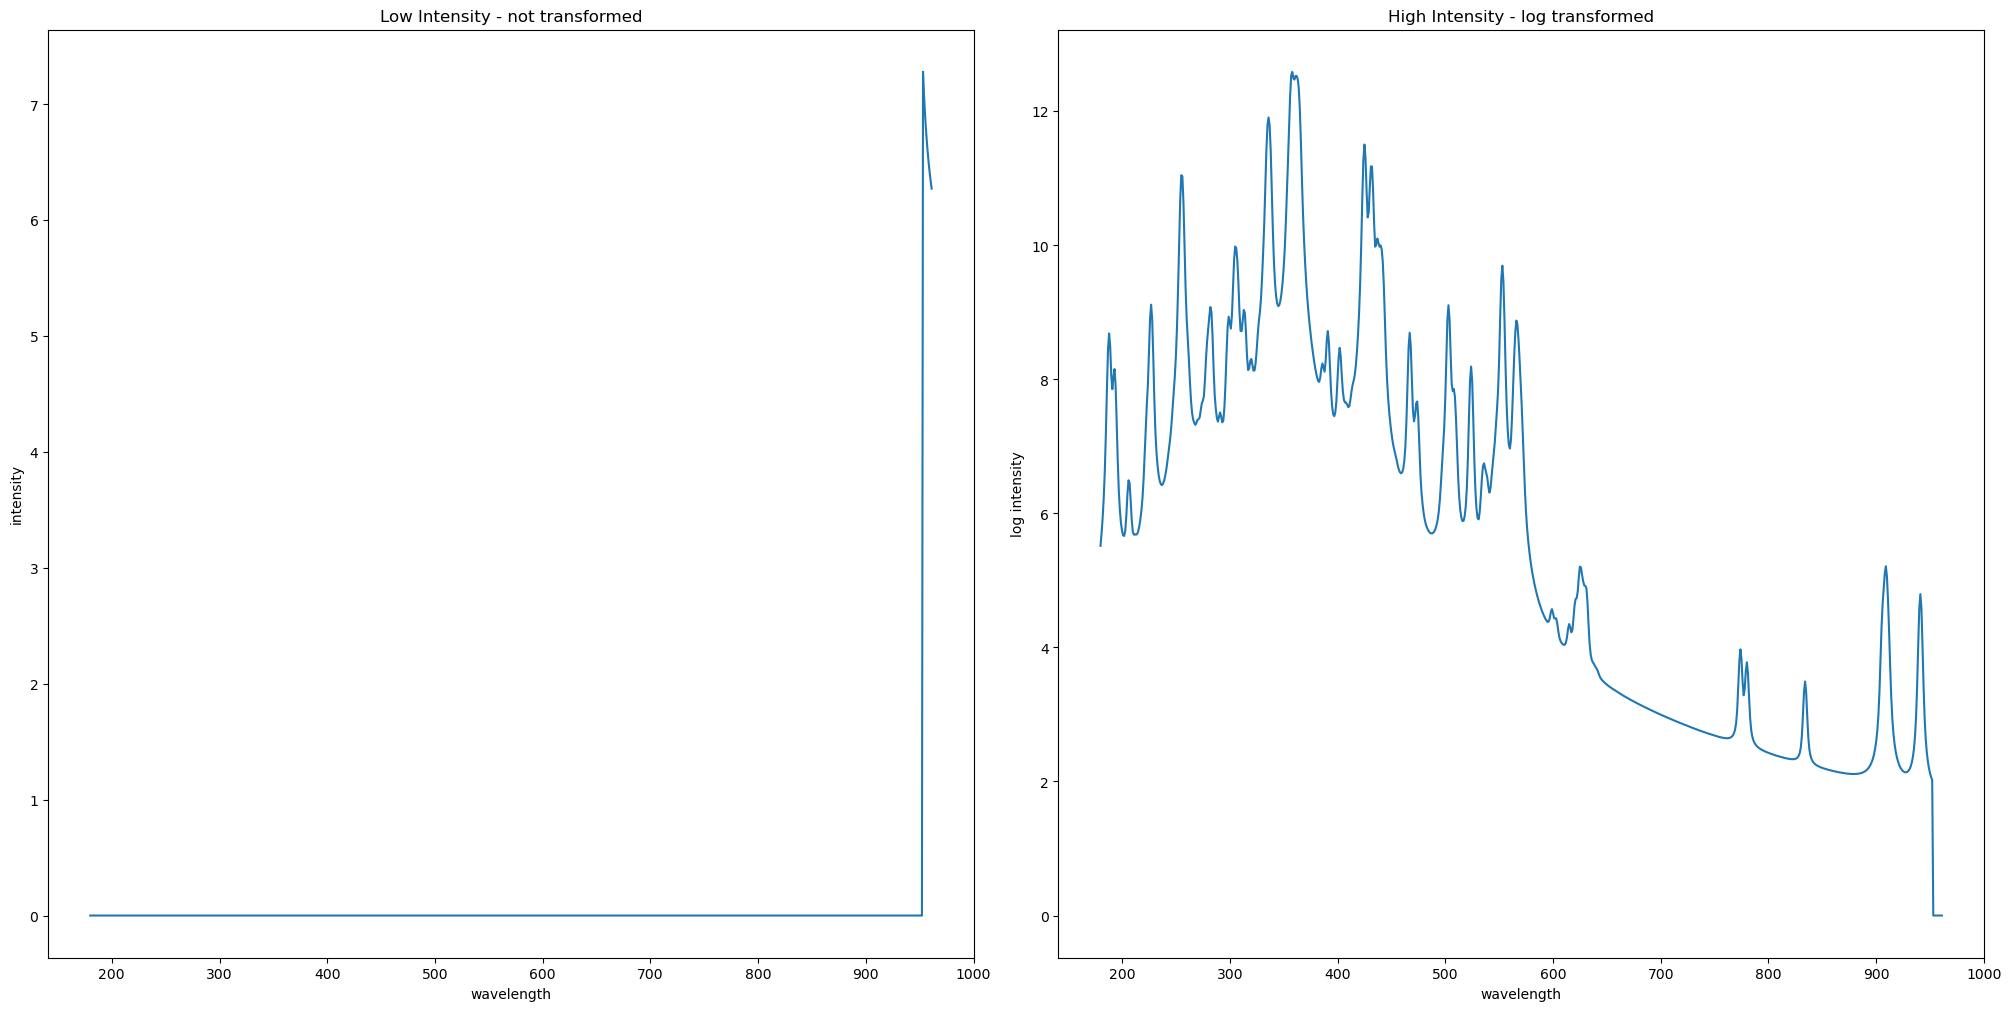

In [58]:
#choose a sample to review
i_samp = 3676 #vary up to 28,520
x_sample, y_sample = spec_ds[i_samp]

#print non-transformed but LIBS scaled input spectra
plt.plot(wave, spec_data[i_samp])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Input Spectrum')
plt.show

#sample composition
print("Sample composition")
for el in elem_symb[np.nonzero(fracs[i_samp])]:
    print(f"{el}:{fracs[i_samp][el_index[el]]:.3f}")

#Model prediction
print("Model Prediction")
cutoff = 0.05
pred_samp = pred[i_samp].detach().numpy().copy()
pred_samp[pred_samp < cutoff] = 0
print(f"max raw pred: {np.max(pred_samp):.2f}")
pred_samp /= np.sum(pred_samp)
for el in elem_symb[np.nonzero(pred_samp)]:
    print(f"{el}:{pred_samp[el_index[el]]:.3f}")

        
#first plot the 2 transformed composite input spectra we're trying to learn from
fig, axs = plt.subplots(1, 2, figsize=(20,10), constrained_layout=True)
axs[0].set_title("Low Intensity - not transformed")
axs[0].plot(wave, x_sample[0])
axs[1].set_title("High Intensity - log transformed")
axs[1].plot(wave, x_sample[1])
[axs[i].set_xlabel('wavelength') for i in range(2)]
axs[0].set_ylabel('intensity')
axs[1].set_ylabel('log intensity')

In [136]:
post_pred = pred.detach().numpy().copy()
post_pred[post_pred < 0.06] = 0
print(f"raw mean: {np.mean(post_pred)}")
print(f"raw stdev: {np.std(post_pred)}")
post_pred /= np.sum(post_pred, axis = 1)[:,None]
print(f"mean: {np.mean(post_pred)}")
print(f"stdev: {np.std(post_pred)}")
diffs = np.abs(post_pred - fracs)
cutoff = 0.09
n_samples = len(fracs)
pct_correct = np.sum(np.sum(diffs < cutoff, axis=1) == 80) / n_samples
pct_correct


raw mean: 0.011730852536857128
raw stdev: 0.08224700391292572
mean: 0.012500002048909664
stdev: 0.08755423128604889


0.7914796633941094

In [137]:
#Bulk measure of accuracy by threshold
#More important for us will be identification with reasonable amount of false+
low_thresh = 0.06 #very sensitive to this, need to look at distribution
diff_tols = np.arange(0.01, 0.11, 0.01)
hit_rates = np.zeros(len(diff_tols))
i = 0
for tol in diff_tols:
    post_pred = pred.detach().numpy().copy()
    post_pred[post_pred < low_thresh] = 0
    divisor = np.sum(post_pred, axis = 1)
    post_pred /= divisor[:,None]
    diffs = np.abs(post_pred - fracs)
    hit_rates[i] = np.sum(np.sum(diffs > tol, axis = 1) == 0) / len(post_pred)
    i += 1

<function matplotlib.pyplot.show(close=None, block=None)>

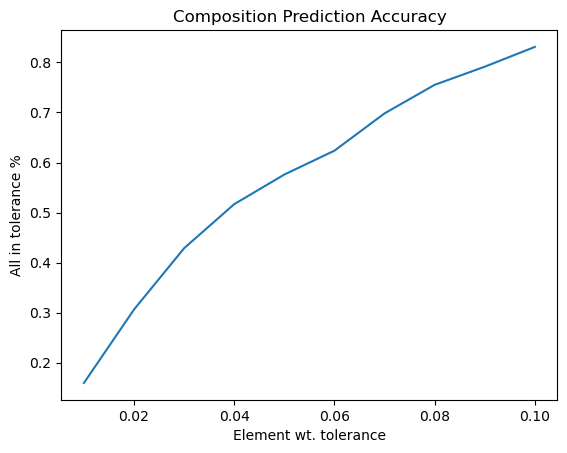

In [138]:
#Plot the percentage of all elements within tolerance vs. tolerance
plt.plot(diff_tols, hit_rates)
plt.xlabel('Element wt. tolerance')
plt.ylabel('All in tolerance %')
plt.title('Composition Prediction Accuracy')
plt.show

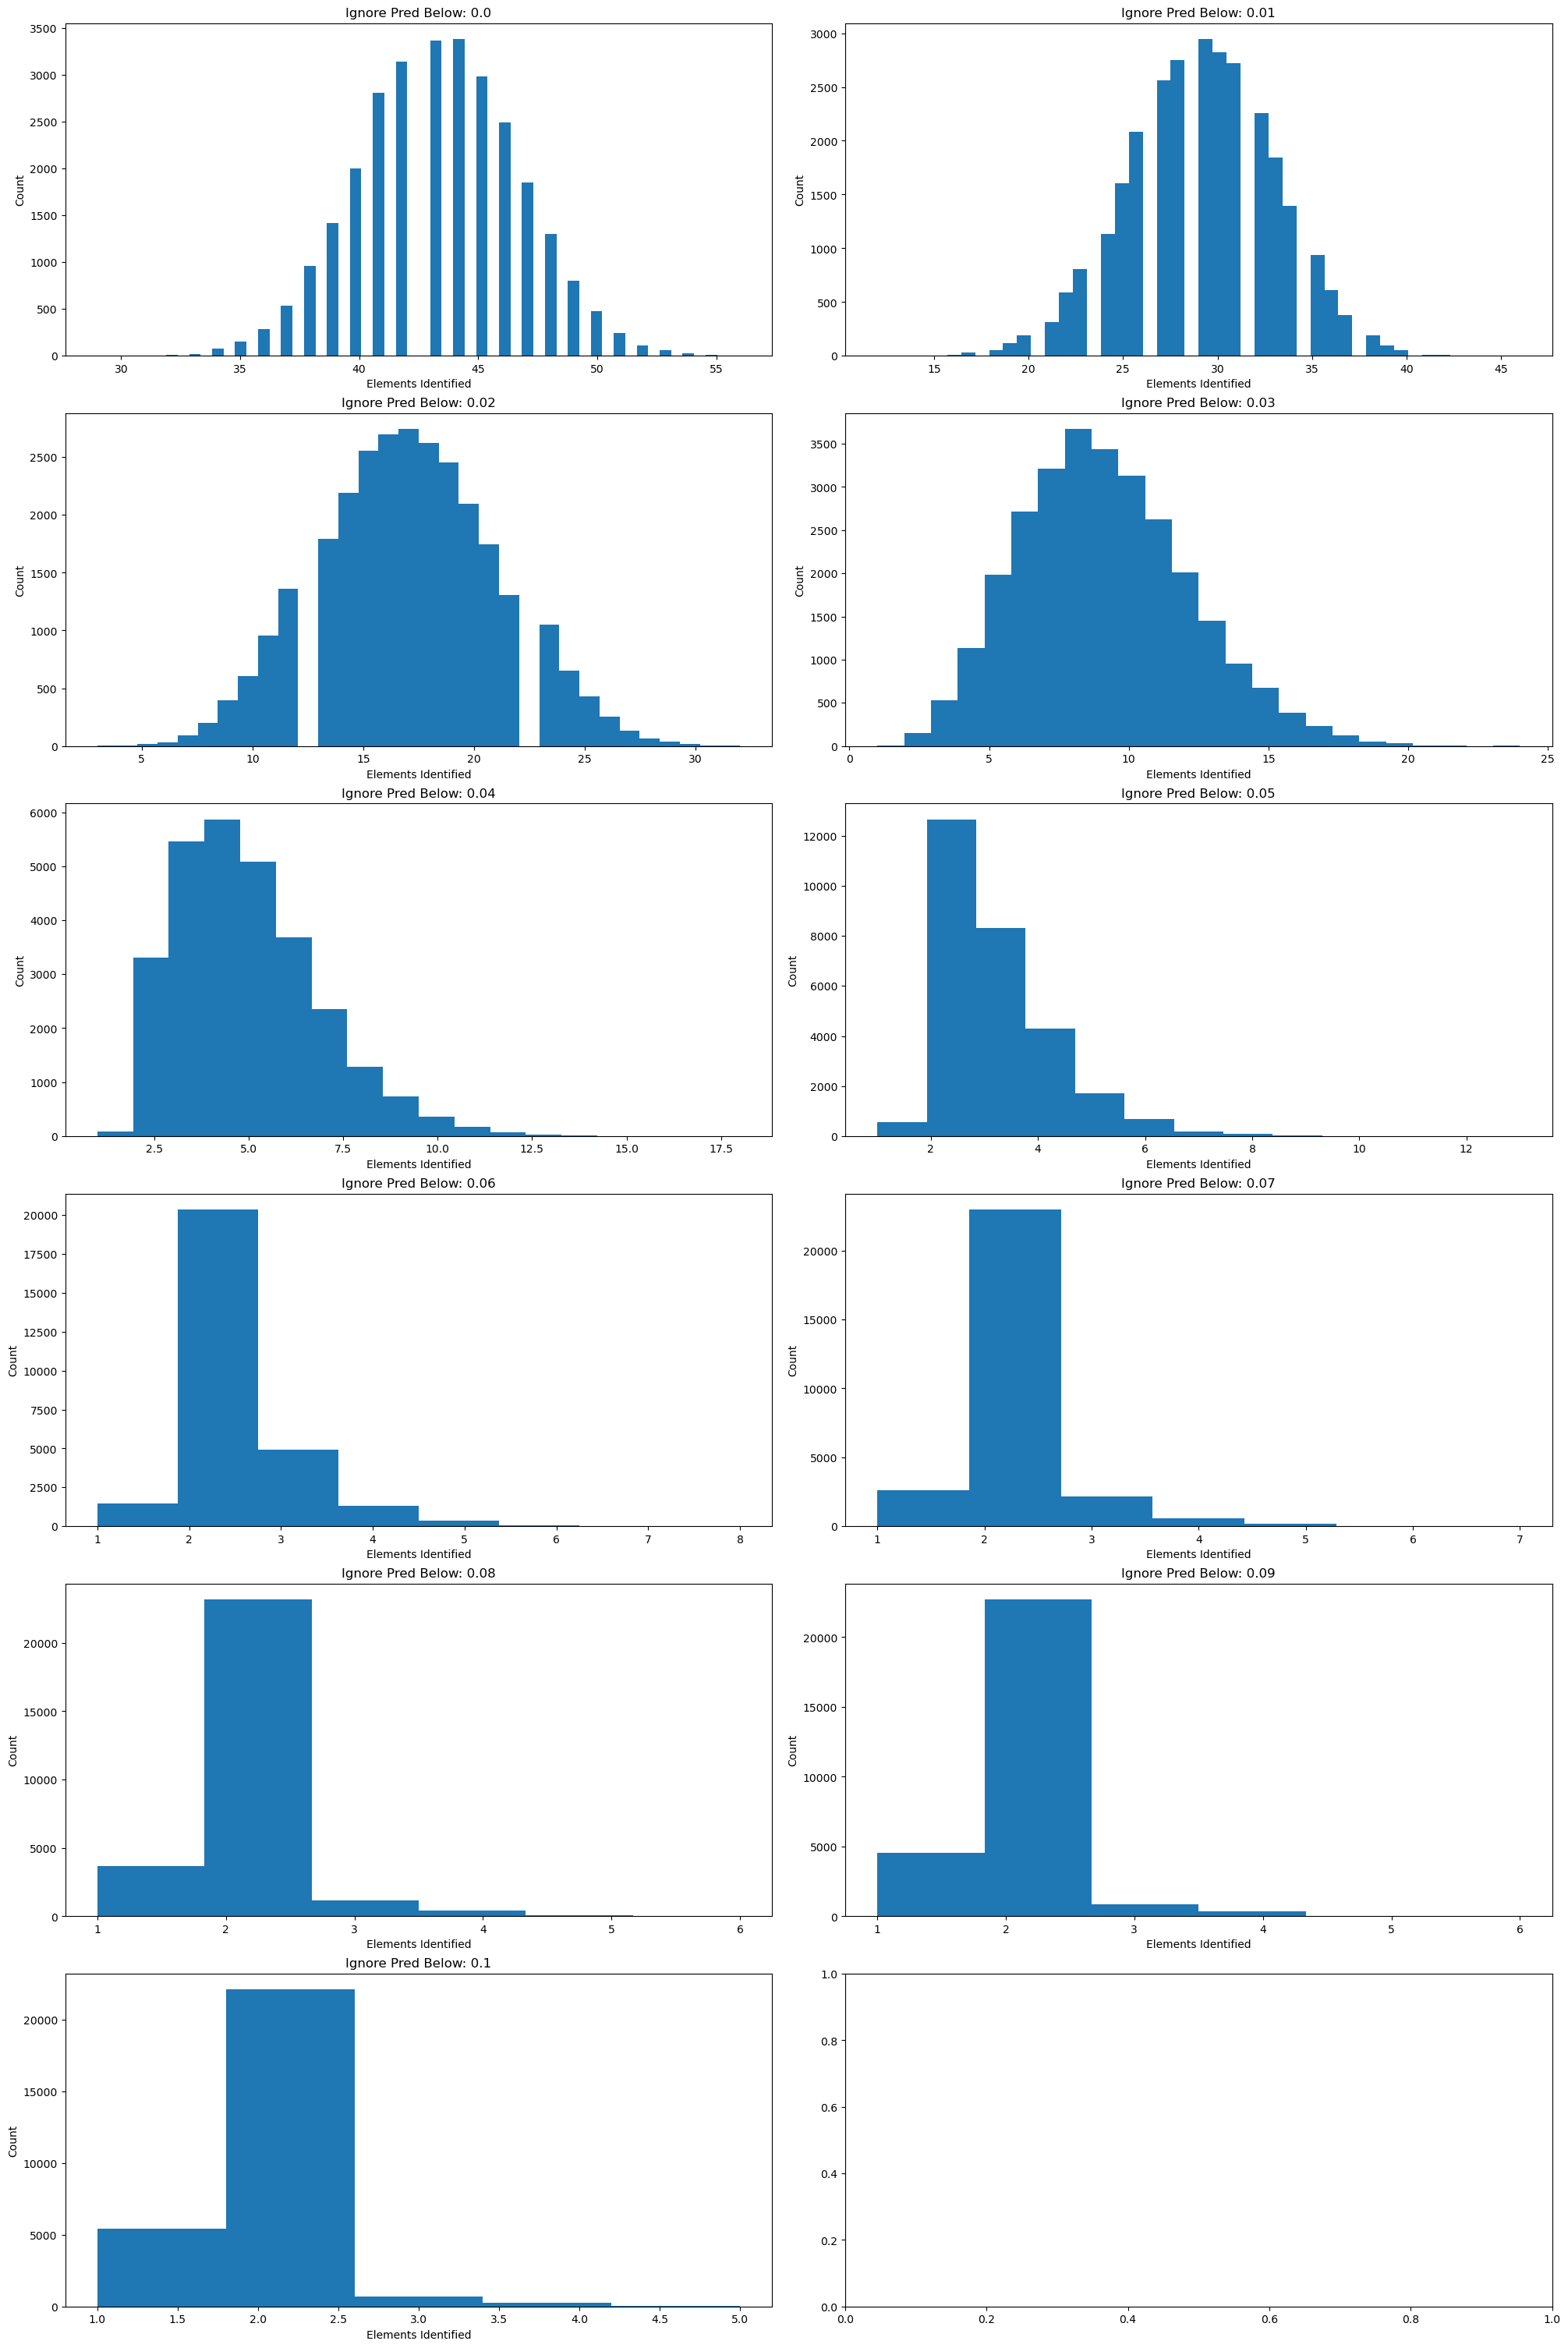

In [31]:
#A separate look now at whether we're getting info that puts the actual target elements in focus.
#Essentially we are going to ~ignore false positives here
#This dataset is 1-2 elements so let's explore the distribution of n predicted elements at various cutoffs
low_thresh = np.arange(0, 0.11, 0.01)
#store the 95th percentile value at each cutoff (e.g. indicative of precision)
el_count95 = np.zeros(len(low_thresh))
fig, axs = plt.subplots(6, 2, figsize=(20,30),constrained_layout=True)
[axs[i // 2][i % 2].set_xlabel('Elements Identified') for i in range(len(low_thresh)) ]
[axs[i // 2][i % 2].set_ylabel('Count') for i in range(len(low_thresh)) ]
i = 0
for thresh in low_thresh:
    post_pred = pred.detach().numpy().copy()
    post_pred[post_pred < thresh] = 0
    #histogram of elements/sample
    elem_counts = np.sum(post_pred > 0, axis=1)
    axs[i // 2][i % 2].hist(elem_counts, bins=np.max(elem_counts))
    axs[i // 2][i % 2].set_title(f'Ignore Pred Below: {thresh}')
    el_count95[i] = np.percentile(elem_counts, 95)
    i += 1

In [153]:
#note: bitwise operators for element-wise comparison
a = np.array([True, False, False])
b = np.array([True, True, True])
a & b

array([ True, False, False])

In [32]:
#For each cutoff, check hit rate of target elements being in that set of identified elements
low_thresh = np.arange(0, 0.11, 0.01)
el_pred_acc = np.zeros(len(low_thresh))
#for each sample, there's a number of elements indicated by np.sum on fracs boolean (generally 2)
el_counts = np.sum(fracs > 0, axis = 1)
i=0
for thresh in low_thresh:
    post_pred = pred.detach().numpy().copy()
    #create boolean array of element presence prediction
    post_pred = post_pred > thresh
    #For each sample we can sum the number of target elements with correct prediction
    #note parentheses since bitwise operator highest precedence order of operations!
    match_counts = np.sum((fracs > 0) & (post_pred > 0), axis = 1)
    #finally we tally the samples where the number of elements matched equals total # elements
    el_pred_acc[i] = np.sum(el_counts == match_counts) / len(post_pred)
    i += 1

Text(0, 0.5, '95th Percentile Predicted Element Count')

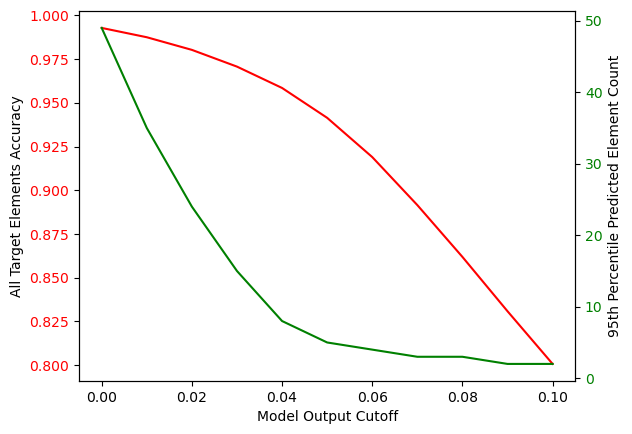

In [33]:
#Plot prediction accuracy as well as indicative upper number of elements at cutoff
fig, ax = plt.subplots()
# Plot prediction accuracy vs. threshold
ax.plot(low_thresh, el_pred_acc, color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel('Model Output Cutoff')
ax.set_ylabel('All Target Elements Accuracy')
# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()
# Plot 95th percentile # elem sequence
ax2.plot(low_thresh, el_count95, color='green')
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel('95th Percentile Predicted Element Count')

In [16]:
#characterize the nature of missed predictions in overall set
# for each element how often missed
# for each element how often incorrectly predicted
# use a low cutoff of 0.06 balancing above
pred_cut = 0.06
false_neg_dict = {}
false_pos_dict = {}
#clean up the prediction array
post_pred = pred.detach().numpy().copy()
post_pred = post_pred > pred_cut #boolean of predicted elements
el_target = fracs > 0
#divisor = np.sum(post_pred, axis = 1)
#post_pred /= divisor[:,None]

for el in elem_symb:
    false_neg_dict[el] = 0
    false_pos_dict[el] = 0

for i in range(len(post_pred)):
    match = np.array_equal(post_pred[i], el_target[i])
    if not match:
        sample_el = elem_symb[el_target[i]]
        pred_el = elem_symb[post_pred[i]]
        #log any missed elements
        for el in sample_el:
            if el not in pred_el:
                false_neg_dict[el] += 1
        #log any false predictions
        for el in pred_el:
            if el not in sample_el:
                false_pos_dict[el] += 1

<BarContainer object of 80 artists>

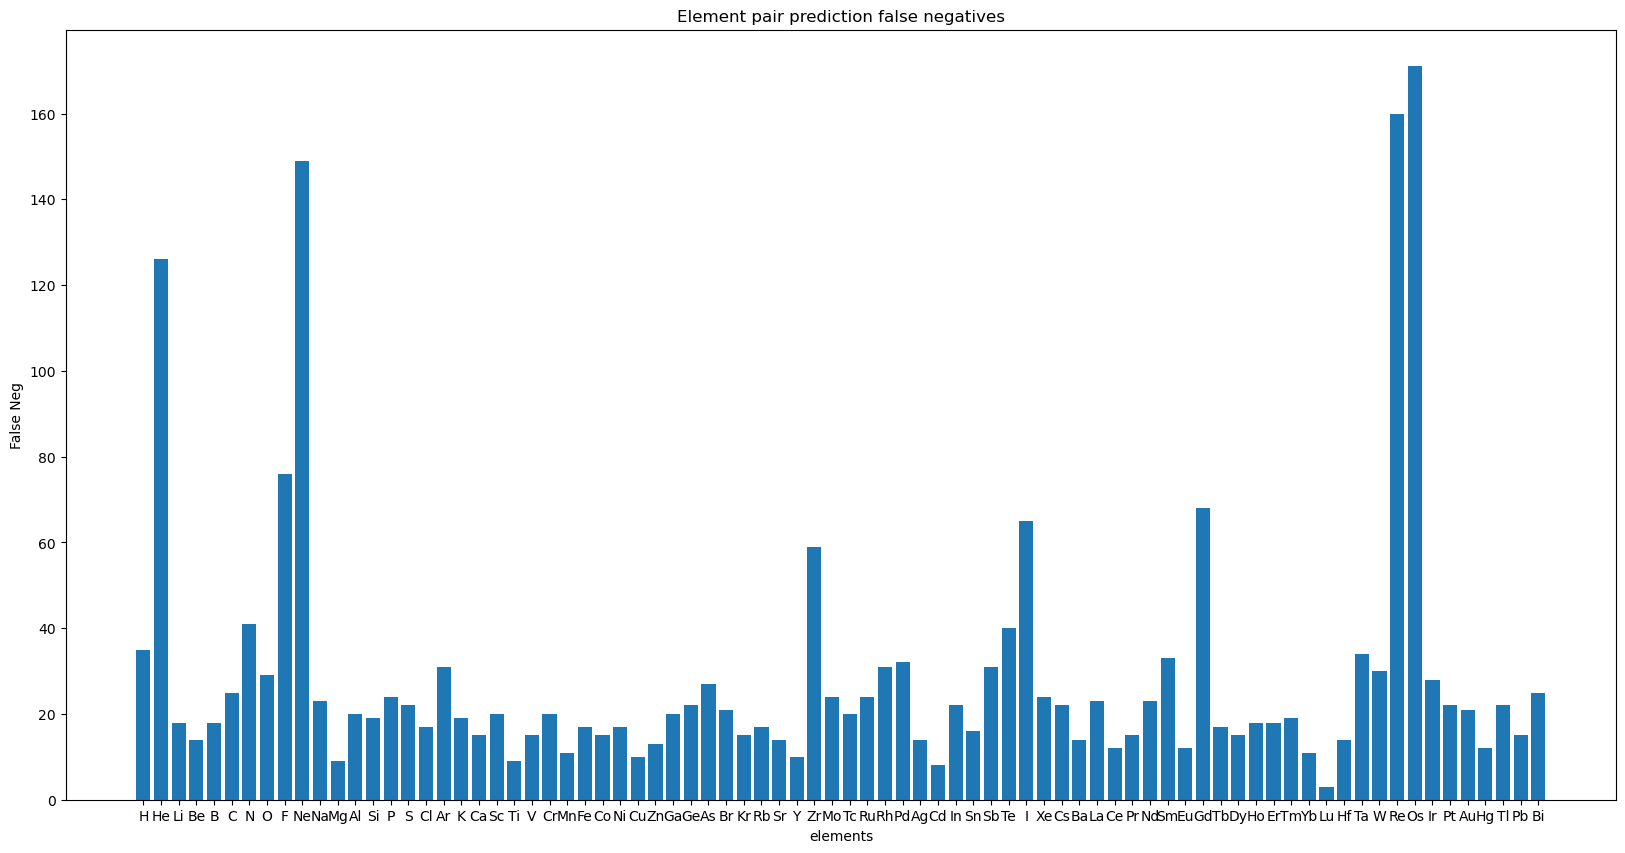

In [17]:
#Visualize false negatives
f_neg_x = np.array([])
f_neg_y = np.array([])
for x, y in false_neg_dict.items():
    f_neg_x = np.append(f_neg_x, x)
    f_neg_y = np.append(f_neg_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Neg')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false negatives')  # Add a title to the axes.
ax.bar(f_neg_x, f_neg_y)

In [18]:
#Check if the pure elements were identified/learned
#This informs whether rescaling / iteration will likely work
for i in range(max_z):
    if not post_pred[i][i]: #check ith element of ith sample since pure elements at start
        print(f"missed element: {elem_symb[i]}")

<BarContainer object of 80 artists>

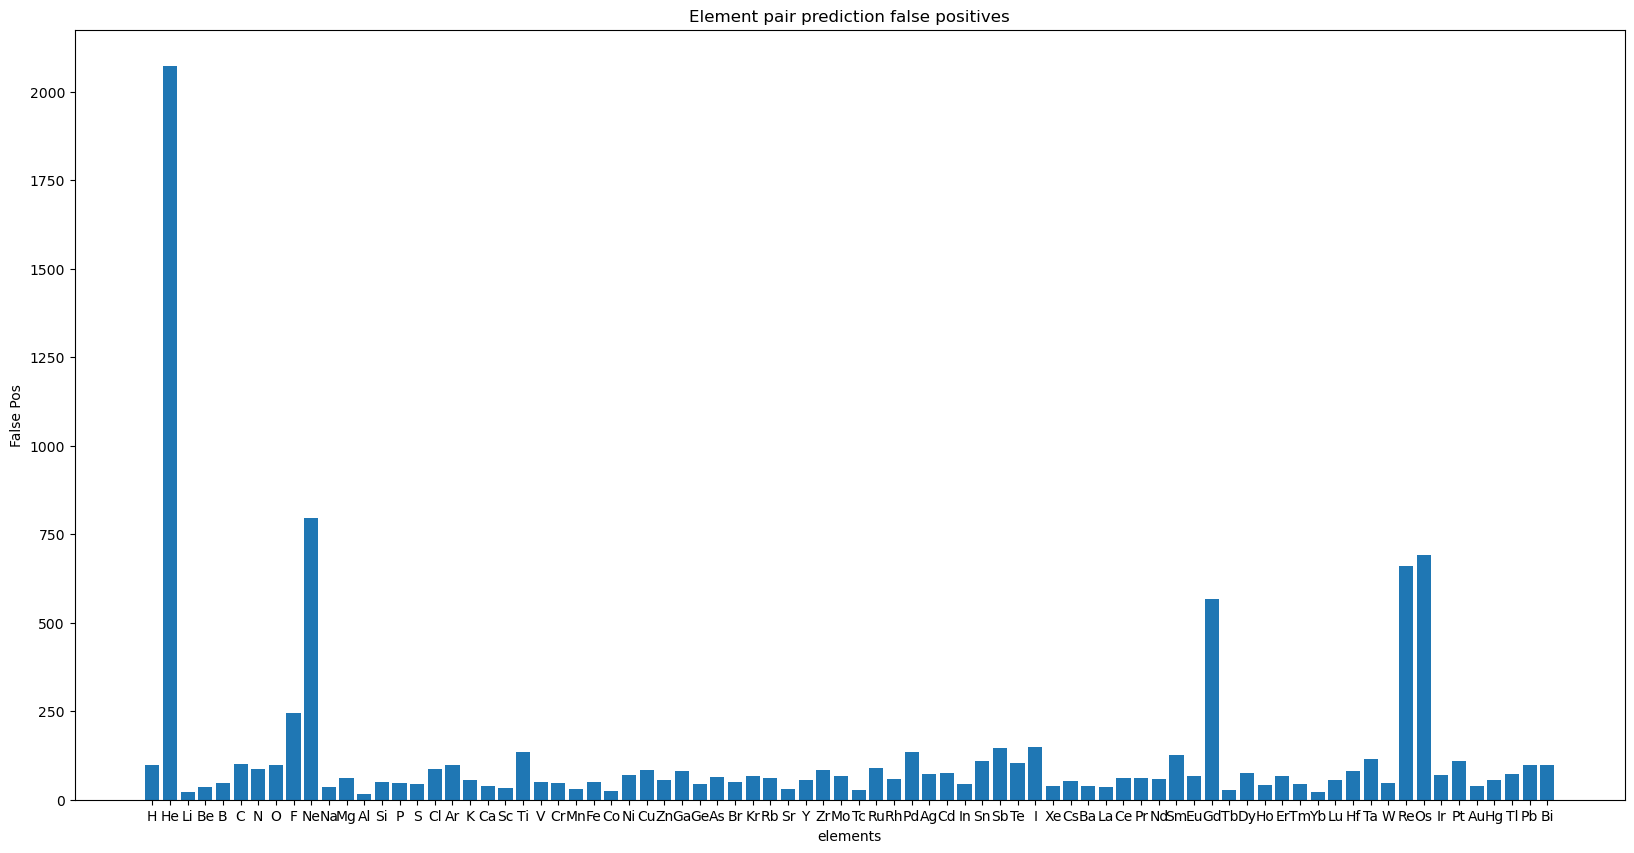

In [19]:
#Visualize false positives
f_pos_x = np.array([])
f_pos_y = np.array([])
for x, y in false_pos_dict.items():
    f_pos_x = np.append(f_pos_x, x)
    f_pos_y = np.append(f_pos_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Pos')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false positives')  # Add a title to the axes.
ax.bar(f_pos_x, f_pos_y)

In [20]:
#check if this model can identify elements in Li2CO3

max_z = len(elem_symb)
spec_maker = spectrum_maker()
fracs_dict = {'Li':0.333, 'C':0.167, 'O':0.5}
wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict)
x_custom = spec_dict['comp']

#scale and dimension data for model
x_custom = nist_mult * x_custom
x_custom = x_custom[None,None,:]
x_shape = x_custom.shape
new_inp = np.zeros((x_shape[0], 2, x_shape[2]))
log_cut = 2
new_inp[:,0,:] = np.where(np.log(x_custom[:,0,:]) < log_cut, x_custom[:,0,:], 0)
new_inp[:,1,:] = np.where(np.log(x_custom[:,0,:]) >= log_cut, np.log(x_custom[:,0,:]), 0)
x_custom = new_inp.copy()
new_inp = None

x_custom = torch.tensor(x_custom.astype('float32'))
x_custom[x_custom < 0] = 0

model.eval()
with torch.no_grad():
    pred_c = model(x_custom).detach().numpy().copy()
pred_c = np.squeeze(pred_c) #remove channel sample dim

pred_c[pred_c < pred_cut] = 0
pred_c = pred_c / np.sum(pred_c)

print("elements predicted")
print(elem_symb[pred_c > 0])

#print predicted elements and weights
for i in range(len(pred_c)):
    if pred_c[i] > 0:
        print(f"{elem_symb[i]}: {pred_c[i]}")


elements predicted
['Li' 'C' 'O']
Li: 0.370774507522583
C: 0.12544408440589905
O: 0.5037814378738403


This and/or other element identification models can feed into a LS fitting model constrained by these allowed elements. The model will find the LS fit of weighted atomic lines to the unknown spectra. The weights will correspond to the element abundance in the unknown sample.